In [1]:
## Importando Bibliotecas

import os
import sys
import pandas as pd
import numpy as np

#Plots
import matplotlib.pyplot as plt
import seaborn as sns

# `do not disturb` mode
import warnings                                  
warnings.filterwarnings('ignore')
                           
# Dates Manipulation
from dateutil.relativedelta import relativedelta 
from datetime import datetime, timedelta
import holidays
import calendar

# statistics
import statsmodels.formula.api as smf            
import statsmodels.tsa.api as smt
import statsmodels.api as sm

#Signal Processing
import scipy as sp
import scipy.fftpack
from scipy.optimize import minimize

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

sns.set_style("darkgrid", {"axes.facecolor": ".9"})
sns.set_context("paper")

params = {'figure.figsize': [12, 6], 
          'axes.labelsize': 16,
          'axes.titlesize':18, 
          'font.size': 16,
          'legend.fontsize': 12, 
          'xtick.labelsize': 12, 
          'ytick.labelsize': 12
         }

plt.rcParams.update(params)


# Seta display de x linhas
pd.set_option('display.max_row', 100)
# Seta display de x colunas
pd.set_option('display.max_columns', 15)

## Funções e Configurações

#######  function [GRNN]=grnn_v1(p,t,spread) #######
def train_matrix(p, t, spread):
    #Cria Matriz de Treinamento: 
    
    # p -> Matriz contendo os vetores de entrada
    # t -> Matriz contendo os vetores de saída
    # spread -> valor do spread que será utilizado
    
    #Cria matriz com as matrizes de entrada p e t
    GRNN=np.zeros((1+t.shape[0]+p.shape[0],t.shape[1]))
    
    # Verifica o número de padrões utilizados no treinamento "n"
    if p.shape[1] == t.shape[1]: 
        # número de entradas do vetor de entrada "ne"
        GRNN[0,0]=p.shape[0]
        # número de saídas do vetor de saída "ns"
        GRNN[0,1]=t.shape[0]
        # Spread
        GRNN[0,2]=spread
        
        #vetores de entrada P
        GRNN[1:1+p.shape[0],:]=p
        #Vetores de saída T
        GRNN[1+p.shape[0]:1+p.shape[0]+t.shape[0],:]=t
    return GRNN;

### GRNN

####### Função que implementa a GRNN #######

def implementa_grnn(GRNN, X): 
    
    # GRNN - Saída da Função grnn_v1(p,t,spread) #
    # X    - Valor a ser aproximado #

    # Definição de ne, n
    sizep = [GRNN[0,0], GRNN.shape[1]] 
    
    # Definição de ns, n
    sizet = [GRNN[0,1], GRNN.shape[1]] 
    
    # Parâmetro spread
    spread = GRNN[0,2]

    
    p = GRNN[1:1+int(sizep[0]),:]
    t = GRNN[1+int(sizep[0]):1+int(sizep[0])+int(sizet[0]),:]

    c1 = np.zeros((int(sizep[0]),int(sizep[1])))
    c3 = np.zeros((1,int(sizep[1])))
    
    num = np.zeros((int(sizet[0]),int(sizet[1])))
    den = np.copy(c3)
    
    Y = np.zeros((int(sizet[0]),np.size(X,1)))
    A = np.zeros((int(sizep[0]),int(sizep[1])))

    if (p.shape[0] == X.shape[0]):
        for i in range(X.shape[1]):
            for k in range(int(sizep[0])):
                A[k,:] = X[k,i]*np.ones((1,int(sizep[1])))
            c1 = abs(A-p)**2
            # soma "MATRIZ"
            c2 = np.sqrt(c1.sum(axis=0)) 
            
    ########### Aqui é a GRNN ########### 

            for j in range(int(sizep[1])): 
                c3[0,j] = (1)*np.exp(-(0.8326*c2[j]/spread)**2)
                for k in range(int(sizet[0])):
                    num[k,j] = t[k,j]*c3[0,j]
                den[0,j] = c3[0,j]
                
    ########################################

            for k in range(int(sizet[0])):
                #Y(k,i)=sum(num(k,:)/(sum(den)+1e-9)
                Y[k,i]=(np.sum(num[k,:])/(np.sum(den)+0.0000000001))
    return Y

### GRNN Modificada

####### Função que implementa a GRNN Modificada #######

def implementa_grnn_mod(GRNN, X, nmax): 
    
    # GRNN - Saída da Função grnn_v1(p,t,spread) #
    # X    - Valor a ser aproximado #
    
    # Definição de ne, n
    sizep=[GRNN[0,0], GRNN.shape[1]]
    
    # Definição de ns, n
    sizet=[GRNN[0,1], GRNN.shape[1]] 
    
    # Parâmetro spread
    spread=GRNN[0,2]

    p=GRNN[1:1+int(sizep[0]),:]
    t=GRNN[1+int(sizep[0]):1+int(sizep[0])+int(sizet[0]),:]

    c1=np.zeros((int(sizep[0]),int(sizep[1])))
    c3=np.zeros((1,nmax))

    num=np.zeros((int(sizet[0]),int(sizet[1])))
    den=np.copy(c3)
    
    Y=np.zeros((int(sizet[0]), X.shape[1]))
    A=np.zeros((int(sizep[0]),int(sizep[1])))
    
    if (p.shape[0] == X.shape[0]):
        for i in range(X.shape[1]):      
            for k in range(int(sizep[0])):
                A[k,:]=X[k,i]*np.ones((1,int(sizep[1])))
            
            c1=abs(A-p)**2
            
            # soma "MATRIZ"
            c2=np.sqrt(c1.sum(axis=0))

########### Aqui é a GRNN modificada ###########
        
            ind_c2 = np.argsort(c2)
            ord_c2 = np.sort(c2)
        
            for j in range(nmax): 
                
                c3[0,j]=(1)*np.exp(-(0.8326*ord_c2[j]/spread)**2)
                
                for k in range(int(sizet[0])):
                    
                    num[k,j]=t[k,ind_c2[j]]*c3[0,j]
                    
                den[0,j]=c3[0,j]
                
####################################################
            
            for k in range(int(sizet[0])):
                Y[k,i]=(np.sum(num[k,:])/(np.sum(den)+0.0000000001))
    return Y

def teste_grnn(testes_input_1, out, columns_n, GRNN_com):

    for (i, j) in zip(testes_input_1, range(len(testes_input_1))):


        if(j==0):
            matriz = np.matrix(i.T)

            teste_x = pd.DataFrame(implementa_grnn(GRNN_com, matriz),\
                                   index = out.index, columns = out.columns)

            stats_d1 = load_statistics_2(ajeita_df(teste_x), 'data_med', 'carga')
            stats_d1.index = pd.DatetimeIndex(stats_d1.index) + pd.DateOffset(1)
            #print(j)
            #print(stats_d1)

            result = teste_x

        else:

            new_df = pd.concat([i, stats_d1], axis=1, join = 'inner')
            #print(new_df)
            matriz = np.matrix(new_df.T)

            teste_x = pd.DataFrame(implementa_grnn(GRNN_com, matriz),\
                                   index = out.index, columns = out.columns)

            df = ajeita_df(teste_x)
            stats_d1 = load_statistics_2(df, 'data_med', 'carga')
            stats_d1.index = pd.DatetimeIndex(stats_d1.index) + pd.DateOffset(j+1)

            #print(j)
            #print(stats_d1)

            result = pd.concat([result, teste_x], axis=1)

    result.columns = columns_n
    return result

### Avaliação de Desempenho

def mape(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def emax(y_true, y_pred): 
    return np.max(np.abs((y_true - y_pred) / y_true)) * 100

### Pré Processamento

## Filtra os datasets para o ano de 2018

def filteryear(df):
    df = df[(df['year']) == 2018]
    return df

#Normaliza os valorews de carga

def normalize(df, new_column, column):
    df[new_column] = df[column]/max(df[column])

def extract_time(df):
    df['time'] = df['data_medicao'].dt.time

## Pega o mês de Referência

def get_month(df):
    df['inp_month'] = df['month']/12

## Pega o mês de Referência - Perídodo Cíclico

def get_month_saw(df):
    if df['month'] == 1:
        return 0.8333
    elif df['month'] == 2:
        return 0.6667
    elif df['month'] == 3:
        return 0.5000
    elif df['month'] == 4:
        return 0.3333
    elif df['month'] == 5:
        return 0.1667
    elif df['month'] == 6:
        return 0
    elif df['month'] == 7:
        return 0.1667
    elif df['month'] == 8:
        return 0.3333
    elif df['month'] == 9:
        return 0.5000
    elif df['month'] == 10:
        return 0.6667
    elif df['month'] == 11:
        return 0.8333
    else:
        return 1

def month_saw(df):
     df['inp_month'] = df.apply (lambda row: get_month_saw(row), axis=1)

## Pega dummies para os dias da semana

def getmon(df):
    
    if df['week_day'] == 'MONDAY' :
        return 1
    else :
        return 0
    
def gettue_res(df):    
    if df['week_day'] == 'TUESDAY' :
        return 1
    else :
        return 0
    
def getwed_res(df):    
    if df['week_day'] == 'WEDNESDAY' :
        return 1
    else :
        return 0

def getthu_res(df):       
    if df['week_day'] == 'THURSDAY' :
        return 1
    else :
        return 0
    
def getfri_res(df):       
    if df['week_day'] == 'FRIDAY' :
        return 1
    else :
        return 0
    
def getsat(df):       
    if df['week_day'] == 'SATURDAY' :
        return 1
    else :
        return 0
    
def getsun(df):           
    if df['week_day'] == 'SUNDAY' :
        return 1
    else :
        return 0
    
def getweek_ot(df):    
    if df['week_day'] == 'TUESDAY' or df['week_day'] == 'WEDNESDAY' or\
    df['week_day'] == 'THURSDAY' or df['week_day'] == 'FRIDAY':
        return 1
    else :
        return 0

def residential_stats(df):
    df['is_monday'] = df.apply (lambda row: getmon(row), axis=1)

    df['is_tuesday'] = df.apply (lambda row: gettue_res(row), axis=1)

    df['is_wednesday'] = df.apply (lambda row: getwed_res(row), axis=1)
    
    df['is_thursday'] = df.apply (lambda row: getthu_res(row), axis=1)
    
    df['is_friday'] = df.apply (lambda row: getfri_res(row), axis=1)
    
    df['is_saturday'] = df.apply (lambda row: getsat(row), axis=1)
    
    df['is_sunday'] = df.apply (lambda row: getsun(row), axis=1)

def other_stats(df):
    df['is_monday'] = df.apply (lambda row: getmon(row), axis=1)

    df['is_week'] = df.apply (lambda row: getweek_ot(row), axis=1)

    df['is_saturday'] = df.apply (lambda row: getsat(row), axis=1)
    
    df['is_sunday'] = df.apply (lambda row: getsun(row), axis=1)

def load_statistics(df, column1, column2):
    
    # Input: df receives dataframe and column receives string

    result = df.groupby(column1)[column2].agg(['min','max','mean'])
    shift_df = result.shift(periods=1, fill_value=0).reset_index()

    return shift_df

def load_statistics_2(df, column1, column2):
    
    # Input: df receives dataframe and column receives string

    result = df.groupby(column1)[column2].agg(['min','max','mean'])

    return result

def ajeita_df(df):
    
    columns = ['time', 'data_med', 'carga']
    
    df1 = df.stack().reset_index()
    df1.columns = columns
    df1['data_medicao'] = pd.to_datetime(df1['data_med'])  + pd.to_timedelta(df1['time'].astype(str))
    df1 = df1.drop(columns=['time'])
    df1 = df1.sort_values(by = 'data_medicao').reset_index(drop = True)
    
    return df1

def peso_feriado(df, n):
    df['feriado'] = n*df['feriado']

def peso_carga(df, n):
    df['valor_kwh_n'] = n*df['valor_kwh_n']

In [3]:
## Importando os Datasets

# Definindo os nomes das colunas
typing = {'instalacao': 'str'}

#importando o arquivo - Dataset de dados de carga Comerciais
data_com = pd.read_csv(r'C:/Users/vitmi/Desktop/TCC/Data/load_data/Data_sp_mean.csv', encoding='utf-8', 
                       sep = ';', decimal = '.',  dtype = typing, parse_dates = ['data_medicao'])

data_com = filteryear(data_com)
month_saw(data_com)
extract_time(data_com)
max_comercial = max(data_com['valor_kwh'])
normalize(data_com, 'valor_kwh_n', 'valor_kwh')

peso_feriado(data_com, 1)
peso_carga(data_com, 1)

## Pré Processamento

data_com_group = pd.DataFrame(data_com.groupby(by = ['data_med', 'inp_month', 'hora_verao', 'feriado', 'week_day'])\
                                 ['valor_kwh'].mean()).reset_index(drop = False)
residential_stats(data_com_group)
data_com_group = data_com_group.drop(columns=['data_med', 'valor_kwh', 'week_day'])

data_com_stats = load_statistics(data_com, 'data_med', 'valor_kwh_n')

### Matriz de entrada X

data_mod_com = pd.concat([data_com_group, data_com_stats], axis=1, join="inner").set_index(['data_med'])

#### Treino, Validação e Teste 

### Entrada Comercial - Treino
data_mod_com_tre = data_mod_com.loc['2018-01-01':'2018-11-30']
data_mod_com_tre_m = np.matrix(data_mod_com_tre.T)

#Entrada Comercial - Validação 
data_mod_com_val = data_mod_com.loc['2018-12-01':'2018-12-07']
data_mod_com_val_m = np.matrix(data_mod_com_val.T)

### Entrada Comercial - Teste
data_mod_com_teste1 = data_mod_com.loc['2018-12-08':'2018-12-14']
data_mod_com_teste2 = data_mod_com.loc['2018-12-22':'2018-12-28']

data_mod_com_teste1_08 = pd.DataFrame(data_mod_com_teste1.loc['2018-12-08']).T
data_mod_com_teste1_09 = pd.DataFrame(data_mod_com_teste1.loc['2018-12-09']).T
data_mod_com_teste1_10 = pd.DataFrame(data_mod_com_teste1.loc['2018-12-10']).T
data_mod_com_teste1_11 = pd.DataFrame(data_mod_com_teste1.loc['2018-12-11']).T
data_mod_com_teste1_12 = pd.DataFrame(data_mod_com_teste1.loc['2018-12-12']).T
data_mod_com_teste1_13 = pd.DataFrame(data_mod_com_teste1.loc['2018-12-13']).T
data_mod_com_teste1_14 = pd.DataFrame(data_mod_com_teste1.loc['2018-12-14']).T

data_mod_com_teste2_22 = pd.DataFrame(data_mod_com_teste2.loc['2018-12-22']).T
data_mod_com_teste2_23 = pd.DataFrame(data_mod_com_teste2.loc['2018-12-23']).T
data_mod_com_teste2_24 = pd.DataFrame(data_mod_com_teste2.loc['2018-12-24']).T
data_mod_com_teste2_25 = pd.DataFrame(data_mod_com_teste2.loc['2018-12-25']).T
data_mod_com_teste2_26 = pd.DataFrame(data_mod_com_teste2.loc['2018-12-26']).T
data_mod_com_teste2_27 = pd.DataFrame(data_mod_com_teste2.loc['2018-12-27']).T
data_mod_com_teste2_28 = pd.DataFrame(data_mod_com_teste2.loc['2018-12-28']).T

testes_1 = [data_mod_com_teste1_09, data_mod_com_teste1_10, data_mod_com_teste1_11,\
            data_mod_com_teste1_12, data_mod_com_teste1_13, data_mod_com_teste1_14]

testes_2 = [data_mod_com_teste2_23, data_mod_com_teste2_24, data_mod_com_teste2_25,\
            data_mod_com_teste2_26, data_mod_com_teste2_27, data_mod_com_teste2_28]

for k in testes_1:
    k.drop(columns=['min', 'max', 'mean'], inplace = True)
    
for k in testes_2:
    k.drop(columns=['min', 'max', 'mean'], inplace = True)

### Matriz de Saída Y

data_out_com = pd.pivot_table(data_com, values = 'valor_kwh_n', columns='data_med', index = 'time')

#### Treino, Validação e Teste 

### Saída Comercial - Entrada
data_out_com_tre = data_out_com.T.loc['2018-01-01':'2018-11-30'].T
data_out_com_tre_m = np.matrix(data_out_com_tre)

### Saída Comercial - Validação
data_out_com_val = data_out_com.T.loc['2018-12-01':'2018-12-07'].T

### Saída Comercial - Teste
data_out_com_teste1 = data_out_com.T.loc['2018-12-08':'2018-12-14'].T
data_out_com_teste2 = data_out_com.T.loc['2018-12-22':'2018-12-28'].T

data_out_com_teste1_08 = pd.DataFrame(data_out_com_teste1['2018-12-08'])
out1 = data_out_com_teste1_08

data_out_com_teste2_22 = pd.DataFrame(data_out_com_teste2['2018-12-22'])
out2 = data_out_com_teste2_22

## GRNN - Modelo Comercial

In [15]:
spread = list(np.arange(100, 10000, 50) / 10000)
spread_min = 100

MAPE_MIN_a = np.zeros(np.size(spread))
MAPE_MIN = 100

EMAX_MIN_a = np.zeros(np.size(spread))
EMAX_MIN = 100

In [20]:
for (j, i) in enumerate(spread):

    GRNN_com = train_matrix(data_mod_com_tre_m, data_out_com_tre_m, i)

    x = pd.DataFrame(implementa_grnn(GRNN_com, data_mod_com_val_m),\
                      index = data_out_com_val.index, columns = data_out_com_val.columns)

    df1 = ajeita_df(x)
    df2 = ajeita_df(data_out_com_val)

    MAPE_MIN_a[j] = mape(df2['carga'], df1['carga'])
    EMAX_MIN_a[j] = emax(df2['carga'], df1['carga'])
    
    if(MAPE_MIN_a[j] < MAPE_MIN or EMAX_MIN_a[j] < EMAX_MIN ):
        MAPE_MIN = MAPE_MIN_a[j]
        EMAX_MIN = EMAX_MIN_a[j]
        spread_min = i

In [21]:
spread_min

0.705

In [22]:
MAPE_MIN_a

array([100.        , 100.        , 100.        ,  99.96212869,
        22.70007742,  10.20417719,  10.27143505,  10.322236  ,
        10.35969598,  10.38851591,  10.41013563,  10.42660138,
        10.43942493,  10.45008457,  10.4587399 ,  10.4658341 ,
        10.4717215 ,  10.47665886,  10.48083159,  10.48436775,
        10.4873436 ,  10.48978379,  10.49165913,  10.49288484,
        10.49332146,  10.49277964,  10.49102908,  10.48781092,
        10.48285261,  10.47607924,  10.4671065 ,  10.45571823,
        10.44183642,  10.4254093 ,  10.4081836 ,  10.39023254,
        10.37238584,  10.35880595,  10.34838664,  10.34480763,
        10.34577348,  10.34985137,  10.3619609 ,  10.37878924,
        10.40137538,  10.42882073,  10.46119809,  10.5041593 ,
        10.55079687,  10.6038162 ,  10.65919353,  10.71609834,
        10.77697827,  10.84337082,  10.91333119,  10.98571902,
        11.05898994,  11.13342042,  11.20833533,  11.28494038,
        11.36523613,  11.44823251,  11.53416846,  11.61

In [23]:
EMAX_MIN_a

array([100.        , 100.        , 100.        ,  99.99486383,
        53.4462706 ,  78.87033651,  79.67305712,  80.18686836,
        80.55827212,  80.83433776,  81.0444643 ,  81.20780734,
        81.3371613 ,  81.44128195,  81.52630157,  81.59660734,
        81.65539598,  81.70502646,  81.74724016,  81.78329112,
        81.81401669,  81.83987425,  81.86096593,  81.87706768,
        81.88767214,  81.89204745,  81.88930863,  81.87849491,
        81.85864578,  81.82886919,  81.78839741,  81.73662802,
        81.67314961,  81.59775304,  81.5104303 ,  81.41136345,
        81.30090633,  81.17956148,  81.04795459,  80.90680822,
        80.75691646,  80.59912136,  80.43429202,  80.2633067 ,
        80.08703828,  79.90634293,  79.722052  ,  79.53496697,
        79.34585696,  79.1554587 ,  78.9644785 ,  78.77359576,
        78.58346781,  78.39473546,  78.20802918,  78.02397527,
        77.84320192,  77.6663448 ,  77.49405189,  77.32698745,
        77.16583485,  77.0112982 ,  76.86410271,  76.72

In [24]:
GRNN_com = train_matrix(data_mod_com_tre_m, data_out_com_tre_m, spread_min)
    
x = pd.DataFrame(implementa_grnn(GRNN_com, data_mod_com_val_m),\
                  index = data_out_com_val.index, columns = data_out_com_val.columns)

df1 = ajeita_df(x)
df2 = ajeita_df(data_out_com_val)

MAPE_tre = mape(df2['carga'], df1['carga'])
EMAX_tre = emax(df2['carga'], df1['carga'])

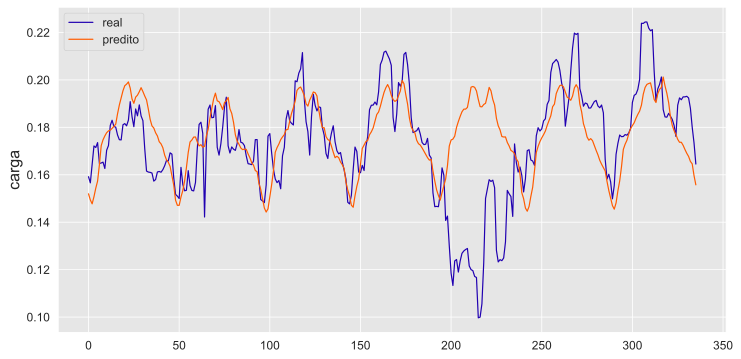

In [25]:
sns.lineplot(data = df2, x=df2.index, y="carga", label = 'real', color = 'xkcd:ultramarine')
sns.lineplot(data = df1, x=df1.index, y="carga",  label = 'predito', color = 'xkcd:bright orange')